In [12]:
import igraph as ig
import pandas as pd

In [13]:
comments_df = pd.read_csv('reddit_comments.csv')

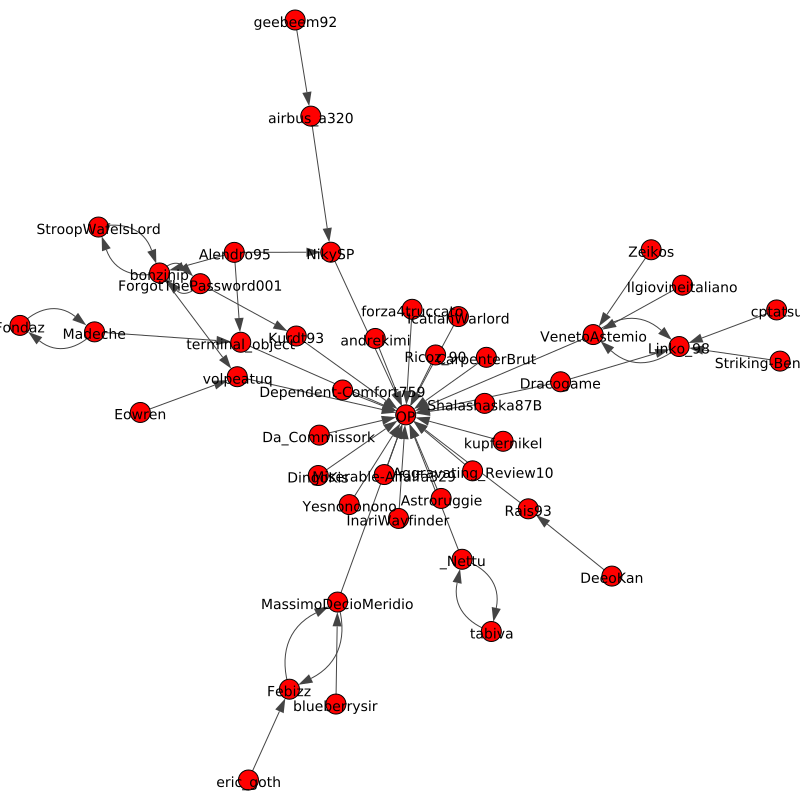

In [14]:
g = ig.Graph(directed=True)
g.add_vertex(name = comments_df.iloc[1]['comment_parent_id'], label = comments_df.iloc[1]['comment_parent_name'])

for comment in comments_df.iloc[1:].iterrows():
    author_id = comment[1]['comment_author_id']
    author_name = comment[1]['comment_author_name']
    parent_id = comment[1]['comment_parent_id']
    if author_id not in g.vs['name']:
        if parent_id in g.vs['name']:
            g.add_vertex(name = author_id, label = author_name)
            g.add_edge(author_id, parent_id)
    else:
        if parent_id in g.vs['name'] and parent_id != author_id:
            g.add_edge(author_id, parent_id)

ig.plot(g, bbox=(0,0,800,800))

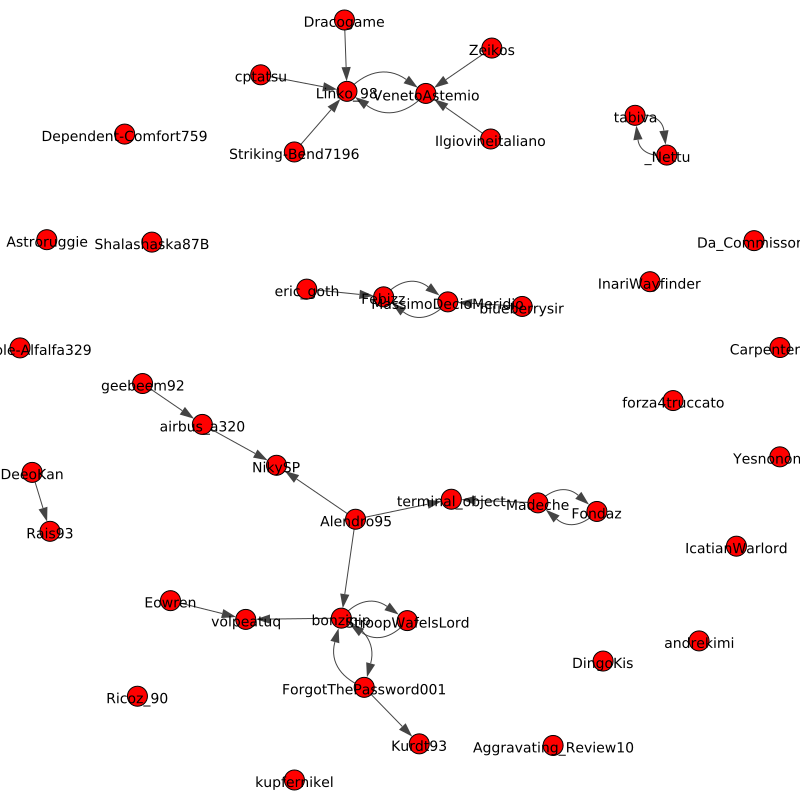

In [15]:
g.delete_vertices(['0'])
ig.plot(g, bbox=(0,0,800,800))